<a href="https://colab.research.google.com/github/jadinsstewart/Cloud-Services/blob/main/Final_NBA_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ella Archie (earchie@calpoly.edu)

Jadin Stewart (jsstewar@calpoly.edu)

GSB S521-01

March 6th, 2023

# <center> **Impact of Home Game Advantage by Sport** <center/>

# Introduction

In our previous analysis, we found a positive relationship between the percent of seats occupied in a stadium and the percent of home games that each NBA team wins. To further our analysis, we have decided to broaden our scope to four different leagues/sports: NBA (Basketball), MLB (Baseball), NFL (Football), and MLS (Soccer). We are looking to see if home field advantage impacts the percent of home games won differently based on the sport.

# Hypothesis

Due to the smaller stadium size and shorted distance between the fans and players, we predict that the NBA is going to be more impacted by playing in their own stadium than the MLB, NFL, or MLS. This means that they will have the greatest home field advantage (Percent of Home Games Won - Percent of Home Games Lost)

In [77]:
import pandas as pd  
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Data Wrangling

## NBA Data

In [78]:
nba = pd.read_html("https://www.covers.com/sport/basketball/nba/standings/2021-2022")
nba_df = nba[0]
nba_df = nba_df.drop(nba_df.columns[[6,7,8,9]], axis=1)
nba_df.columns = ("Team", "Wins", "Losses", "Win Percent", "Home Record", "Away Record", "b", "c", "d", "e")
nba_df = nba_df.drop(columns=['b', 'c', 'd', 'e'])

team_names = {"Boston":"Celtics","Philadelphia":"76ers","Toronto":"Raptors", "Brooklyn":"Nets","New York":"NY Knicks",
              "Milwaukee":"Bucks","Chicago":"Bulls","Cleveland":"Cavaliers","Indiana":"Pacers",
              "Detroit":"Pistons","Miami":"Heat","Atlanta":"Hawks","Charlotte":"Hornets",
              "Washington":"Wizards","Orlando":"Magic","Utah":"Jazz","Denver":"Nuggets","Minnesota":"Timberwolves",
              "Portland":"Trail Blazers","Oklahoma City":"Thunder","Phoenix":"Suns","Golden State":"Warriors",
              "L.A. Clippers": "Clippers", "L.A. Lakers":"Lakers","Sacramento":"Kings","Memphis":"Grizzlies",
              "Dallas":"Mavericks", "New Orleans":"Knicks","San Antonio":"Spurs","Houston":"Rockets"}

nba_df['Team'] = nba_df['Team'].map(team_names)
my_split = nba_df['Home Record'].str.split("-", n = 1, expand = True)
nba_df['Home Wins'] = my_split[0]
nba_df['Home Losses'] = my_split[1]
nba_df['Home Wins'] = pd.to_numeric(nba_df['Home Wins'])
nba_df['Home Losses'] = pd.to_numeric(nba_df['Home Losses'])
nba_df['Total Home Games'] = nba_df['Home Wins'] + nba_df['Home Losses']
nba_df['Home Win Percent'] = (nba_df['Home Wins'] / nba_df['Total Home Games']) * 100

my_split2 = nba_df['Away Record'].str.split("-", n = 1, expand = True)
nba_df['Away Wins'] = my_split2[0]
nba_df['Away Losses'] = my_split2[1]
nba_df['Away Wins'] = pd.to_numeric(nba_df['Away Wins'])
nba_df['Away Losses'] = pd.to_numeric(nba_df['Away Losses'])
nba_df['Total Away Games'] = nba_df['Away Wins'] + nba_df['Away Losses']
nba_df['Away Win Percent'] = (nba_df['Away Wins'] / nba_df['Total Away Games']) * 100
nba_df['Home Advantage'] = nba_df['Home Win Percent'] - nba_df['Away Win Percent']

nba_df['Path'] = nba_df['Team'] + '.png'

## MLB Data

In [79]:
# Home Record
mlb_home = pd.read_html("https://www.teamrankings.com/mlb/trends/win_trends/?sc=is_home&range=yearly_mlb_2021")
mlb_home_df = mlb_home[0]
mlb_home_df = mlb_home_df.drop(mlb_home_df.columns[[2,3,4]], axis=1)
mlb_home_df.columns = ("Team", "Home Record")
my_split = mlb_home_df['Home Record'].str.split("-", n = 2, expand = True)
mlb_home_df['Home Wins'] = my_split[0]
mlb_home_df['Home Losses'] = my_split[1]
mlb_home_df['Home Ties'] = my_split[2]
mlb_home_df['Home Wins'] = pd.to_numeric(mlb_home_df['Home Wins'])
mlb_home_df['Home Losses'] = pd.to_numeric(mlb_home_df['Home Losses'])
mlb_home_df['Home Ties'] = pd.to_numeric(mlb_home_df['Home Ties'])
mlb_home_df['Total Home Games'] = mlb_home_df['Home Wins'] + mlb_home_df['Home Losses'] + mlb_home_df['Home Ties']
mlb_home_df['Home Win Percent'] = (mlb_home_df['Home Wins'] / mlb_home_df['Total Home Games']) * 100

In [80]:
# Away Record
mlb_away = pd.read_html("https://www.teamrankings.com/mlb/trends/win_trends/?sc=is_away&range=yearly_mlb_2021")
mlb_away_df = mlb_away[0]
mlb_away_df = mlb_away_df.drop(mlb_away_df.columns[[2,3,4]], axis=1)
mlb_away_df.columns = ("Team", "Away Record")
my_split2 = mlb_away_df['Away Record'].str.split("-", n = 2, expand = True)
mlb_away_df['Away Wins'] = my_split2[0]
mlb_away_df['Away Losses'] = my_split2[1]
mlb_away_df['Away Ties'] = my_split2[2]
mlb_away_df['Away Wins'] = pd.to_numeric(mlb_away_df['Away Wins'])
mlb_away_df['Away Losses'] = pd.to_numeric(mlb_away_df['Away Losses'])
mlb_away_df['Away Ties'] = pd.to_numeric(mlb_away_df['Away Ties'])
mlb_away_df['Total Away Games'] = mlb_away_df['Away Wins'] + mlb_away_df['Away Losses'] + mlb_away_df['Away Ties']
mlb_away_df['Away Win Percent'] = (mlb_away_df['Away Wins'] / mlb_away_df['Total Away Games']) * 100

In [81]:
# Merge
mlb_df = pd.merge(mlb_home_df, mlb_away_df, on=["Team", "Team"])
mlb_df['Home Advantage'] = mlb_df['Home Win Percent'] - mlb_df['Away Win Percent']

## NFL Data

In [82]:
nfl = pd.read_html("https://www.nfl.com/standings/league/2021/reg")
nfl_df = nfl[0]
nfl_df = nfl_df.drop(nfl_df.columns[[1,2,3,4,5,6,7,10,11,12,13,14,15,16]], axis=1)
my_split = nfl_df['Home'].str.split("-", n = 2, expand = True)
nfl_df['Home Wins'] = my_split[0]
nfl_df['Home Losses'] = my_split[1]
nfl_df['Home Ties'] = my_split[2]
nfl_df['Home Wins'] = pd.to_numeric(nfl_df['Home Wins'])
nfl_df['Home Losses'] = pd.to_numeric(nfl_df['Home Losses'])
nfl_df['Home Ties'] = pd.to_numeric(nfl_df['Home Ties'])
nfl_df['Total Home Games'] = nfl_df['Home Wins'] + nfl_df['Home Losses'] + nfl_df['Home Ties']
nfl_df['Home Win Percent'] = (nfl_df['Home Wins'] / nfl_df['Total Home Games']) * 100

my_split2 = nfl_df['Road'].str.split("-", n = 2, expand = True)
nfl_df['Away Wins'] = my_split2[0]
nfl_df['Away Losses'] = my_split2[1]
nfl_df['Away Ties'] = my_split2[2]
nfl_df['Away Wins'] = pd.to_numeric(nfl_df['Away Wins'])
nfl_df['Away Losses'] = pd.to_numeric(nfl_df['Away Losses'])
nfl_df['Away Ties'] = pd.to_numeric(nfl_df['Away Ties'])
nfl_df['Total Away Games'] = nfl_df['Away Wins'] + nfl_df['Away Losses'] + nfl_df['Away Ties']
nfl_df['Away Win Percent'] = (nfl_df['Away Wins'] / nfl_df['Total Away Games']) * 100
nfl_df['Home Advantage'] = nfl_df['Home Win Percent'] - nfl_df['Away Win Percent']
nfl_df.rename(columns = {"NFL Team": "Team"}, inplace = True)

team_messy = {'Detroit LionsLions': 'Detroit Lions', 'Jacksonville JaguarsJaguars': 'Jacksonville Jaguars',
                      'Houston TexansTexans': 'Houston Texans', 'New York GiantsGiants': 'New York Giants', 
                      'New York JetsJets': 'New York Jets', 'Carolina PanthersPanthers': 'Carolina Panthers',
                      'Chicago BearsBears': 'Chicago Bears', 'Atlanta FalconsFalcons': 'Atlanta Falcons', 
                      'Denver BroncosBroncos': 'Denver Broncos', 'Seattle SeahawksSeahawks': 'Seattle Seahawks',
                      'Washington CommandersFootball Team': 'Washington Commanders', 'Baltimore RavensRavens': 'Baltimore Ravens', 
                      'Cleveland BrownsBrowns': 'Cleveland Browns', 'Minnesota VikingsVikings': 'Minnesota Vikings', 
                      'Indianapolis ColtsColts': 'Indianapolis Colts', 'Los Angeles ChargersChargers': 'Los Angeles Chargers', 
                      'Miami DolphinsDolphins': 'Miami Dolphins', 'New Orleans SaintsSaints': 'New Orleans Saints',
                      'Philadelphia Eagles xyEagles xy': 'Philadelphia Eagles', 'Pittsburgh Steelers xySteelers xy': 'Pittsburgh Steelers', 
                      'Cincinnati Bengals xzBengals xz': 'Cincinnati Bengals', 'Las Vegas Raiders xyRaiders xy': 'Las Vegas Raiders',
                      'New England Patriots xyPatriots xy': 'New England Patriots', 'San Francisco 49ers xy49ers xy': 'San Francisco 49ers', 
                      'Arizona Cardinals xyCardinals xy': 'Arizona Cardinals', 'Buffalo Bills xzBills xz': 'Buffalo Bills',
                      'Dallas Cowboys xzCowboys xz': 'Dallas Cowboys', 'Kansas City Chiefs xzChiefs xz': 'Kansas City Chiefs', 
                      'Los Angeles Rams xzRams xz': 'Los Angeles Rams', 'Tennessee Titans xz*Titans xz*': 'Tennessee Titans',
                      'Green Bay Packers xz*Packers xz*': 'Green Bay Packers', 'Tampa Bay Buccaneers xzBuccaneers xz': 'Tampa Bay Buccaneers'}

nfl_df['Team'] = nfl_df['Team'].map(team_messy)

## MLS Data

In [83]:
# Home
mls = pd.read_html("https://footballdatabase.com/league-scores-tables/united-states-mls-2021")
mls_home_df = mls[1]
mls_home_df = mls_home_df.drop(mls_home_df.columns[[0,2,3,8,9]], axis=1)
mls_home_df.columns = ("Team", "Total Home Games", "Home Wins", "Home Ties", "Home Losses")
mls_home_df['Home Wins'] = pd.to_numeric(mls_home_df['Home Wins'])
mls_home_df['Home Losses'] = pd.to_numeric(mls_home_df['Home Losses'])
mls_home_df['Home Ties'] = pd.to_numeric(mls_home_df['Home Ties'])
mls_home_df['Total Home Games'] = pd.to_numeric(mls_home_df['Total Home Games'])
mls_home_df['Home Win Percent'] = (mls_home_df['Home Wins'] / mls_home_df['Total Home Games']) * 100

In [84]:
# Away
mls = pd.read_html("https://footballdatabase.com/league-scores-tables/united-states-mls-2021")
mls_away_df = mls[2]
mls_away_df = mls_away_df.drop(mls_away_df.columns[[0,2,3,8,9]], axis=1)
mls_away_df.columns = ("Team", "Total Away Games", "Away Wins", "Away Ties", "Away Losses")
mls_away_df['Away Wins'] = pd.to_numeric(mls_away_df['Away Wins'])
mls_away_df['Away Losses'] = pd.to_numeric(mls_away_df['Away Losses'])
mls_away_df['Away Ties'] = pd.to_numeric(mls_away_df['Away Ties'])
mls_away_df['Total Away Games'] = pd.to_numeric(mls_away_df['Total Away Games'])
mls_away_df['Away Win Percent'] = (mls_away_df['Away Wins'] / mls_away_df['Total Away Games']) * 100

In [85]:
# Merge
mls_df = pd.merge(mls_home_df, mls_away_df, on=["Team", "Team"])
mls_df['Home Advantage'] = mls_df['Home Win Percent'] - mls_df['Away Win Percent']

## Merged Data Frame

In [86]:
nba_df['Sport'] = 'Basketball'
mlb_df['Sport'] = 'Baseball'
nfl_df['Sport'] = 'Football'
mls_df['Sport'] = 'Soccer'
nba_df = nba_df[['Team', 'Home Win Percent', 'Away Win Percent', 'Home Advantage', 'Sport']]
mlb_df = mlb_df[['Team', 'Home Win Percent', 'Away Win Percent', 'Home Advantage', 'Sport']]
nfl_df = nfl_df[['Team', 'Home Win Percent', 'Away Win Percent', 'Home Advantage', 'Sport']]
mls_df = mls_df[['Team', 'Home Win Percent', 'Away Win Percent', 'Home Advantage', 'Sport']]
sports_df = pd.concat([nba_df, mlb_df, nfl_df, mls_df], axis=0)




# Exploring the Data 

In [87]:
# Home Advantage Percent Descending 

df_descending = sports_df.sort_values("Home Advantage",ascending=False)

desc = df_descending[["Team", "Home Advantage", "Sport"]]

# top 10 teams
print(desc.head(20))

                    Team  Home Advantage       Sport
9    Vancouver Whitecaps       47.058824      Soccer
5              DC United       47.058824      Soccer
1     Philadelphia Union       47.058824      Soccer
30     Green Bay Packers       44.444444    Football
12      Cleveland Browns       41.666667    Football
7          Columbus Crew       41.176471      Soccer
8       Minnesota United       41.176471      Soccer
0          Detroit Lions       37.500000    Football
14           CF Montreal       35.294118      Soccer
3       New York City FC       35.294118      Soccer
20        Houston Dynamo       35.294118      Soccer
1   Jacksonville Jaguars       33.333333    Football
11     Atlanta United FC       29.411765      Soccer
19          Chicago Fire       29.411765      Soccer
21             Austin FC       29.411765      Soccer
2       Portland Timbers       29.411765      Soccer
13     Minnesota Vikings       29.166667    Football
19   Pittsburgh Steelers       29.166667    Fo

In [88]:
# Home Advantage Percent Ascending 

df_ascending = sports_df.sort_values("Home Advantage")

asc = df_ascending[["Team", "Home Advantage", "Sport"]]

# top 10 teams
print(asc.head(20))

                     Team  Home Advantage       Sport
24      Arizona Cardinals      -51.388889    Football
7         Atlanta Falcons      -30.555556    Football
22   New England Patriots      -30.555556    Football
17     New Orleans Saints      -29.166667    Football
18    Philadelphia Eagles      -29.166667    Football
14     Indianapolis Colts      -18.055556    Football
23    San Francisco 49ers      -16.666667    Football
28       Los Angeles Rams      -15.277778    Football
26         Dallas Cowboys      -15.277778    Football
26          FC Cincinnati      -11.764706      Soccer
3                    Nets       -9.756098  Basketball
5       Carolina Panthers       -8.333333    Football
1                   76ers       -7.317073  Basketball
4               NY Knicks       -7.317073  Basketball
9        Seattle Seahawks       -6.944444    Football
21      Las Vegas Raiders       -6.944444    Football
20     Cincinnati Bengals       -6.944444    Football
10  Washington Commanders   

# Visualizations

## Boxplot of Home Advantage by Sport

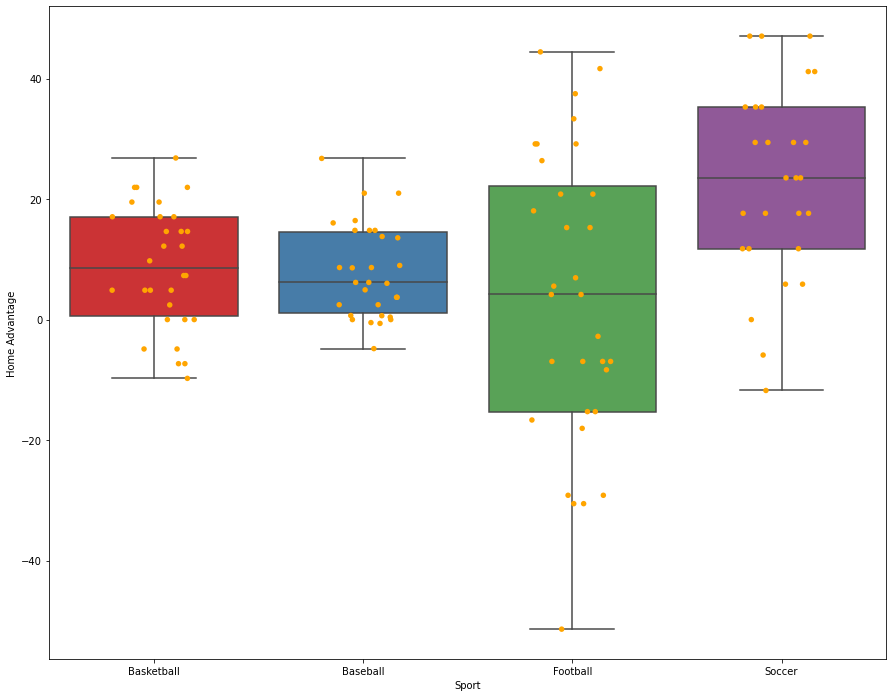

In [89]:
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.boxplot(x='Sport', y='Home Advantage', data = sports_df, ax = ax, palette = "Set1")
ax = sns.stripplot(x='Sport', y='Home Advantage', data = sports_df, color = "orange", jitter = 0.2, size = 5.5, ax = ax)

# show the graph
plt.show()

# Glimpse of Average Home Advantage by Sport

In [90]:
sports_df.groupby(['Sport']).mean()

,Home Win Percent,Away Win Percent,Home Advantage
Sport,,,
Baseball,53.853040,45.874534,7.978506
Basketball,54.390244,45.609756,8.780488
Football,51.302083,47.960069,3.342014
Soccer,47.930283,25.054466,22.875817


# Statistical Analysis - ANOVA

Null Hypothesis: The average home advantage is the same across each sport

Alternative Hypothesis: At least one of the sports has a different average home advantage

In [91]:
stats.f_oneway(sports_df['Home Advantage'][sports_df['Sport'] == 'Baseball'],
               sports_df['Home Advantage'][sports_df['Sport'] == 'Basketball'],
               sports_df['Home Advantage'][sports_df['Sport'] == 'Football'],
               sports_df['Home Advantage'][sports_df['Sport'] == 'Soccer'])

F_onewayResult(statistic=7.7705719437513245, pvalue=9.046481756569901e-05)

Test Statistic: 7.770571943751326

P-Value: 9.046481756569759e-05

Conclusion: Reject the null hypothesis. At least one of the sports has a different average home advantage.

# Statistcal Analysis - T Tests

### Baseball vs. Basketball Home Advantage

In [92]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Baseball'], sports_df['Home Advantage'][sports_df['Sport'] == 'Basketball'], equal_var=True)

Ttest_indResult(statistic=-0.34375422925591964, pvalue=0.7322742066857274)

No significant differnece

### Baseball vs. Football Home Advantage

In [93]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Baseball'], sports_df['Home Advantage'][sports_df['Sport'] == 'Football'], equal_var=True)

Ttest_indResult(statistic=0.9943646737808914, pvalue=0.3240387229482464)

No significant difference

### Baseball vs. Soccer Home Advantage

In [94]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Baseball'], sports_df['Home Advantage'][sports_df['Sport'] == 'Soccer'], equal_var=True)


Ttest_indResult(statistic=-4.538646644900702, pvalue=3.121844201351725e-05)

Significant difference

### Basketball vs. Football Home Advantage

In [95]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Basketball'], sports_df['Home Advantage'][sports_df['Sport'] == 'Football'], equal_var=True)

Ttest_indResult(statistic=1.132451324902994, pvalue=0.2619501333694169)

No significant difference

### Basketball vs. Soccer Home Advantage

In [96]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Basketball'], sports_df['Home Advantage'][sports_df['Sport'] == 'Soccer'], equal_var=True)

Ttest_indResult(statistic=-4.011787603540923, pvalue=0.00018357350781414726)

Significant difference

### Football vs. Soccer Home Advantage

In [97]:
stats.ttest_ind(sports_df['Home Advantage'][sports_df['Sport'] == 'Football'], sports_df['Home Advantage'][sports_df['Sport'] == 'Soccer'], equal_var=True)

Ttest_indResult(statistic=-3.561395071589911, pvalue=0.0007529788934772796)

Significant difference

# Conclusion

Based on the visualizations, tables, and statistical tests above, we can see that there is not a significant differnece between the average home advantage of basketball, football, and baseball. However, soccer has a statistically significant difference in average home advantage from all three other sports. We can see that soccer is most impacted by home field advantage. This goes against our original hypothesis. Moving forward, it would be interesting to investigate how the volume of the stadiums impacts whether a team wins at home or not.